In [1]:
import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**geogFeat =** geogFeat + geogFeat geogName + geogFeat geogName geogName + geogName geogFeat + geogFeat geogName geogName geogName  = **4167**

**geogName =** geogName + name geogName + geogFeat geogName + geogName name + geogFeat geogName geogName + name geogName geogName + geogName geogName + geogName geogFeat geogName + geogName geogName name + geogName name geogName + geogName geogFeat + geogFeat geogName geogName geogName + geogName geogName name geogName 

**geogFeat geogName =** geogFeat geogName + geogFeat geogName geogName + geogName geogFeat geogName + geogName geogFeat + geogFeat geogName geogName geogName = **1469**

**name** = name geogName + geogName name + name geogName geogName + geogName geogName name + geogName name geogName + geogName geogName name geogName 


**name geogName =** name geogName + geogName name + name geogName geogName + geogName geogName name + geogName name geogName + geogName geogName name geogName 


In [2]:
df = pd.read_csv("./defi-textmine-2024/train_2.csv")
df.Label.value_counts()

aucun                32663
geogFeat              2704
geogName name         2117
geogFeat geogName     1463
geogName               910
Name: Label, dtype: int64

In [3]:
# Let's clean the labels
def clean_label(string):
    string = string.split(" ")
    string = " ".join(list(set(string)))  
    return(string)
df["Label"] = df["Label"].apply(clean_label)

def isgeogFeat(string):
    geogFeat = False
    if "geogFeat" in string:
        geogFeat = True
    return(geogFeat)
def isgeogName(string):
    geogName = False
    if "geogName" in string:
        geogName = True
    return(geogName)
def isName(string):
    Name = False
    if ("name" in string):
        Name = True
    return(Name)

df["Label"] = df["Label"].apply(clean_label)
labels_count = df.Label.value_counts()
labels_count

aucun                32663
geogFeat              2704
name geogName         2117
geogFeat geogName     1463
geogName               910
Name: Label, dtype: int64

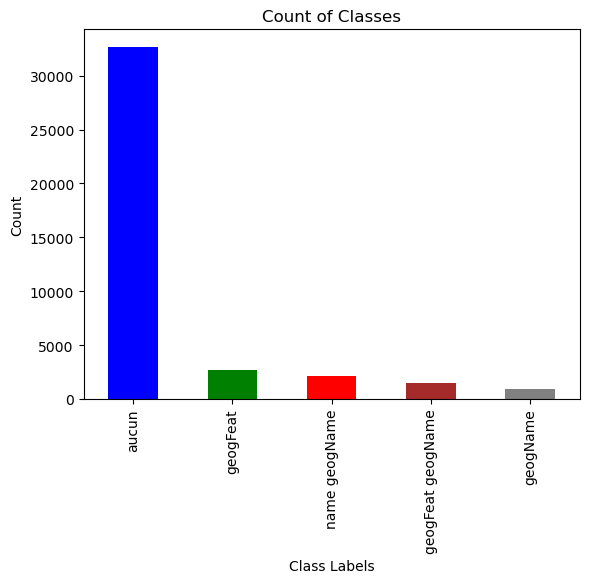

In [6]:
colors = ['blue', 'green', 'red', 'brown', 'grey']
labels_count.plot(kind='bar', color=colors)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Count of Classes')
plt.show()

In [7]:
import spacy.cli
spacy.cli.download("fr_core_news_lg")
df.replace('"', '', regex=True, inplace=True)

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')


### Get the sentences

In [8]:
dot_index = [i for i,v in enumerate(df.Token.tolist()) if v=="."]
sentence = list()
s = 0
for i in list(range(len(df.Token.tolist()))):
    if df.Token.tolist()[i] != ".":
        sentence.append(s)
    else:
        sentence.append(s)
        s = s+1
df['Sentence'] = sentence
df

,Id,Token,Label,Sentence
0,0,01,aucun,0
1,1,4.5.3,aucun,0
2,2,.,aucun,0
3,3,Port,geogFeat geogName,1
4,4,du,geogName,1
...,...,...,...,...
39852,39852,portée,aucun,1701
39853,39853,sur,aucun,1701
39854,39854,les,aucun,1701
39855,39855,cartes,aucun,1701


### Create the training and test sets

In [9]:
from spacy.tokens import Doc
from spacy.training import Example
nlp = spacy.blank("fr")
df.replace('"', '', regex=True, inplace=True)

In [79]:
train_docs = []
for s in list(set(df.Sentence)):
    words = df[df.Sentence == s].Token.tolist()
    labels = df[df.Sentence == s].Label.tolist()
    doc = Doc(nlp.vocab, words=words)
    entities_tmp = []
    for i, w in enumerate(words):
        if i == 0:
            entities_tmp = [(0, len(w), labels[0])]
            start = len(w)+1
        else:
            entities_tmp.append((start, start + len(w), labels[i]))
            start = start + 1 + len(w)
    train_docs.append((" ".join(words), {'entities':entities_tmp}))


In [80]:
train_data, test_data = train_test_split(train_docs, test_size=0.20, random_state=42)
id_sentences_train, id_sentences_test = train_test_split(range(len(train_docs)), test_size=0.20, random_state=42)

In [81]:
len(id_sentences_train)

1361

In [82]:
len(id_sentences_test)

341

### Train the model

In [84]:
from tqdm import tqdm
epocs = 5 

if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add the labels to the NER pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add the labels to the NER pipeline
for _, annotations in train_data:
    for ent in annotations.get('entities'):
     
        ner.add_label(ent[2])


In [95]:
epocs=5
# Initialize the training process
optimizer = nlp.begin_training()

progress_bar = tqdm(total=len(train_data), desc="Training")
# Train the token classification model
for _ in range(epocs):  # Adjust the number of training iterations as needed
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], sgd=optimizer, losses=losses)
        progress_bar.set_postfix(loss=losses["ner"])
        progress_bar.update(1)
progress_bar.close()

model_output_dir = "./defi_finetuned_sentences_5epocs.tar"
nlp.to_disk(model_output_dir)


Training: 6805it [02:31, 44.91it/s, loss=1.13e+3]                                                                      


### Test the model

In [96]:
# Test the trained model on the test set
correct = 0
total = 0
predicted_labels = []
true_labels = []
for text, label in test_data:
    doc = Doc(nlp.vocab, words=text.split(" "))
    #nlp.tagger(doc)
    #nlp.parser(doc)
    nlp.get_pipe("ner")(doc)
    predicted_label = [word.ent_type_ for word in doc]
    predicted_labels = predicted_labels + predicted_label
    tmp_labels = [ent[2] for ent in label.get('entities')]
    true_labels= true_labels + tmp_labels

Accuracy: 0.0


In [97]:
for i, value in enumerate(predicted_labels):
    if value == '':
        predicted_labels[i] = "aucun"

In [88]:
len(predicted_labels)

8586

In [89]:
len(true_labels)

8586

In [98]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("Micro F1-score:", f1_score)

Micro F1-score: 0.9515151562961093


Let's remove the "aucun" class.

In [100]:
ids_without_aucun = [i for i,v in enumerate(true_labels) if v!='aucun']
predicted_without_aucun = [predicted_labels[i] for i in ids_without_aucun]
true_without_aucun = [true_labels[i] for i in ids_without_aucun]

In [101]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_without_aucun, predicted_without_aucun, average='weighted')

print("Micro F1-score:", f1_score)

Micro F1-score: 0.8176943699731903


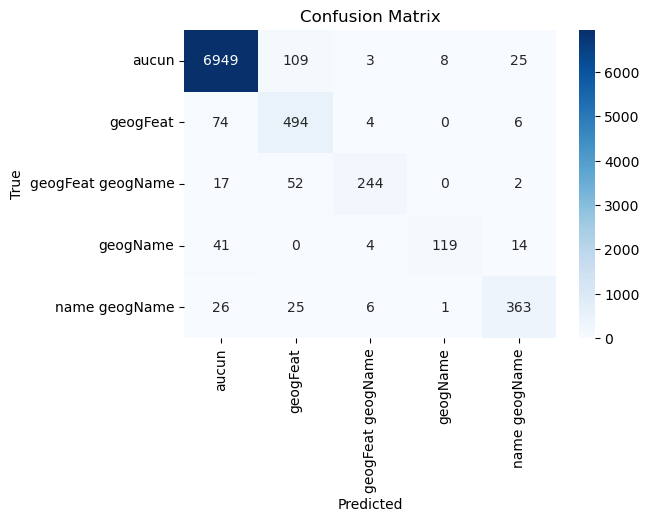

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
# Assuming you have the true labels and predicted labels stored in the variables true_labels and predicted_labels

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the unique class labels
class_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [10]:
from sklearn.metrics import precision_recall_fscore_support
true_labels = [label for _, label in test_data]

precision, recall, f1_score, support = precision_recall_fscore_support(
    true_labels, predicted_labels, average=None
)

# Print the results for each class
for label, prec, rec, f1, supp in zip(nlp.get_pipe("ner").labels, precision, recall, f1_score, support):
    print(f"Class: {label}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1 Score: {f1}")
    print(f"Support: {supp}")
    print("-------------------")

Class: aucun
Precision: 0.9648676932276873
Recall: 0.9891187739463602
F1 Score: 0.9768427425457847
Support: 6525
-------------------
Class: geogFeat
Precision: 0.6938775510204082
Recall: 0.5396825396825397
F1 Score: 0.6071428571428572
Support: 567
-------------------
Class: geogFeat geogName
Precision: 0.7741935483870968
Recall: 0.6813880126182965
F1 Score: 0.7248322147651007
Support: 317
-------------------
Class: geogName
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Support: 160
-------------------
Class: name geogName
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Support: 403
-------------------


### Prediction on test file

In [135]:
df_test = pd.read_csv("./defi-textmine-2024/test.csv")
df_test.replace('"', '', regex=True, inplace=True)

In [104]:
dot_index = [i for i,v in enumerate(df_test.Token.tolist()) if v=="."]
sentence = list()
s = 0
for i in list(range(len(df_test.Token.tolist()))):
    if df.Token.tolist()[i] != ".":
        sentence.append(s)
    else:
        sentence.append(s)
        s = s+1
df_test['Sentence'] = sentence
df_test

,Id,Token,Sentence
0,0,01,0
1,1,2.1.4.8,0
2,2,.,0
3,3,Conduites,1
4,4,sous-marines,1
...,...,...,...
26168,26168,103,1162
26169,26169,/,1162
26170,26170,0,1162
26171,26171,103,1162


In [105]:
predicted_labels = []
for s in list(set(df_test.Sentence)):
    words = df_test[df_test.Sentence == s].Token.tolist()
    doc = Doc(nlp.vocab, words=words)
    nlp.get_pipe("ner")(doc)
    predicted_label = [word.ent_type_ for word in doc]
    predicted_labels = predicted_labels + predicted_label


In [138]:
for index, item in enumerate(predicted_labels):
    if item == '':
        predicted_labels[index] = 'aucun'

In [140]:
df_test['Label'] = predicted_labels

In [142]:
df_test = df_test[['Id', 'Label']]
df_test.to_csv('./defi-textmine-2024/spacy_sentences_fr_epoch5.csv', sep=',', encoding='utf-8', index=False)